In [1]:
import pandas as pd

# File paths
file_paths = {
    "2022-2023": "/content/gsw-shg-en 2022-2023.csv",
    "2023-2024": "/content/gsw-shg-en 2023-2024.csv",
    "2024-2025": "/content/gsw-shg-en 2024-2025.csv",
}

# Load datasets
dataframes = {year: pd.read_csv(path) for year, path in file_paths.items()}

# Display basic information about the datasets
{year: df.info() for year, df in dataframes.items()}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207192 entries, 0 to 207191
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   grain_week        207192 non-null  int64 
 1   crop_year         207192 non-null  object
 2   week_ending_date  207192 non-null  object
 3   worksheet         207192 non-null  object
 4   metric            207192 non-null  object
 5   period            207192 non-null  object
 6   grain             207192 non-null  object
 7   grade             62130 non-null   object
 8   region            202176 non-null  object
 9   Ktonnes           207192 non-null  object
dtypes: int64(1), object(9)
memory usage: 15.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211116 entries, 0 to 211115
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   grain_week        211116 non-null  int64 
 1   crop_year        

{'2022-2023': None, '2023-2024': None, '2024-2025': None}

In [2]:
# Convert data types and handle missing values

for year, df in dataframes.items():
    # Convert week_ending_date to datetime
    df["week_ending_date"] = pd.to_datetime(df["week_ending_date"], errors='coerce')

    # Convert Ktonnes to numeric, forcing errors to NaN (to clean non-numeric values)
    df["Ktonnes"] = pd.to_numeric(df["Ktonnes"], errors='coerce')

    # Fill missing region values with 'Unknown' for now
    df["region"].fillna("Unknown", inplace=True)

# Verify the changes
dataframes["2022-2023"].info(), dataframes["2023-2024"].info(), dataframes["2024-2025"].info()

<ipython-input-2-3f6985f1d881>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["region"].fillna("Unknown", inplace=True)
<ipython-input-2-3f6985f1d881>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207192 entries, 0 to 207191
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   grain_week        207192 non-null  int64         
 1   crop_year         207192 non-null  object        
 2   week_ending_date  85134 non-null   datetime64[ns]
 3   worksheet         207192 non-null  object        
 4   metric            207192 non-null  object        
 5   period            207192 non-null  object        
 6   grain             207192 non-null  object        
 7   grade             62130 non-null   object        
 8   region            207192 non-null  object        
 9   Ktonnes           204464 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 15.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211116 entries, 0 to 211115
Data columns (total 10 columns):
 #   Column            Non-Null Coun

<ipython-input-2-3f6985f1d881>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["region"].fillna("Unknown", inplace=True)


(None, None, None)

In [3]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for Corn and Soybeans from Bay & Lakes and St. Lawrence regions
selected_regions = ["Bay & Lakes", "St. Lawrence"]
selected_grains = ["Corn", "Soybeans"]

# Combine all years into one DataFrame for analysis
df_all_years = pd.concat(dataframes.values())

# Filter dataset for relevant grains and regions
df_filtered = df_all_years[df_all_years["grain"].isin(selected_grains) & df_all_years["region"].isin(selected_regions)]

# Aggregate weekly exports by summing up Ktonnes
df_grouped = df_filtered.groupby(["week_ending_date", "grain", "region"])["Ktonnes"].sum().reset_index()

# Pivot data for stationarity test
df_pivot = df_grouped.pivot(index="week_ending_date", columns=["grain", "region"], values="Ktonnes")

# Perform Augmented Dickey-Fuller (ADF) test for stationarity
adf_results = {}
for col in df_pivot.columns:
    adf_test = adfuller(df_pivot[col].dropna())
    adf_results[col] = {"ADF Statistic": adf_test[0], "p-value": adf_test[1]}

# Convert results to DataFrame for easier visualization
adf_results_df = pd.DataFrame(adf_results).T
adf_results_df

ADF Statistic       p-value
Corn     Bay & Lakes       -3.530691  7.232993e-03
         St. Lawrence      -2.199187  2.065408e-01
Soybeans Bay & Lakes       -2.961327  3.866719e-02
         St. Lawrence      -8.394270  2.321747e-13

from matplotlib import pyplot as plt
adf_results_df['ADF Statistic'].plot(kind='hist', bins=20, title='ADF Statistic')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adf_results_df['p-value'].plot(kind='hist', bins=20, title='p-value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adf_results_df.plot(kind='scatter', x='ADF Statistic', y='p-value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adf_results_df['ADF Statistic'].plot(kind='line', figsize=(8, 4), title='ADF Statistic')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
adf_results_df['p-value'].plot(kind='line', figsize=(8, 4), title='p-value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['ADF Statistic'].plot(kind='hist', bins=20, title='ADF Statistic')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['p-value'].plot(kind='hist', bins=20, title='p-value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('level_0').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('level_1').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='ADF Statistic', y='p-value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['ADF Statistic'].plot(kind='line', figsize=(8, 4), title='ADF Statistic')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['p-value'].plot(kind='line', figsize=(8, 4), title='p-value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['level_1'].value_counts()
    for x_label, grp in _df_7.groupby('level_0')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('level_0')
_ = plt.ylabel('level_1')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['level_0'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='ADF Statistic', y='level_0', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['level_1'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='ADF Statistic', y='level_1', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['level_0'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='p-value', y='level_0', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['level_1'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='p-value', y='level_1', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

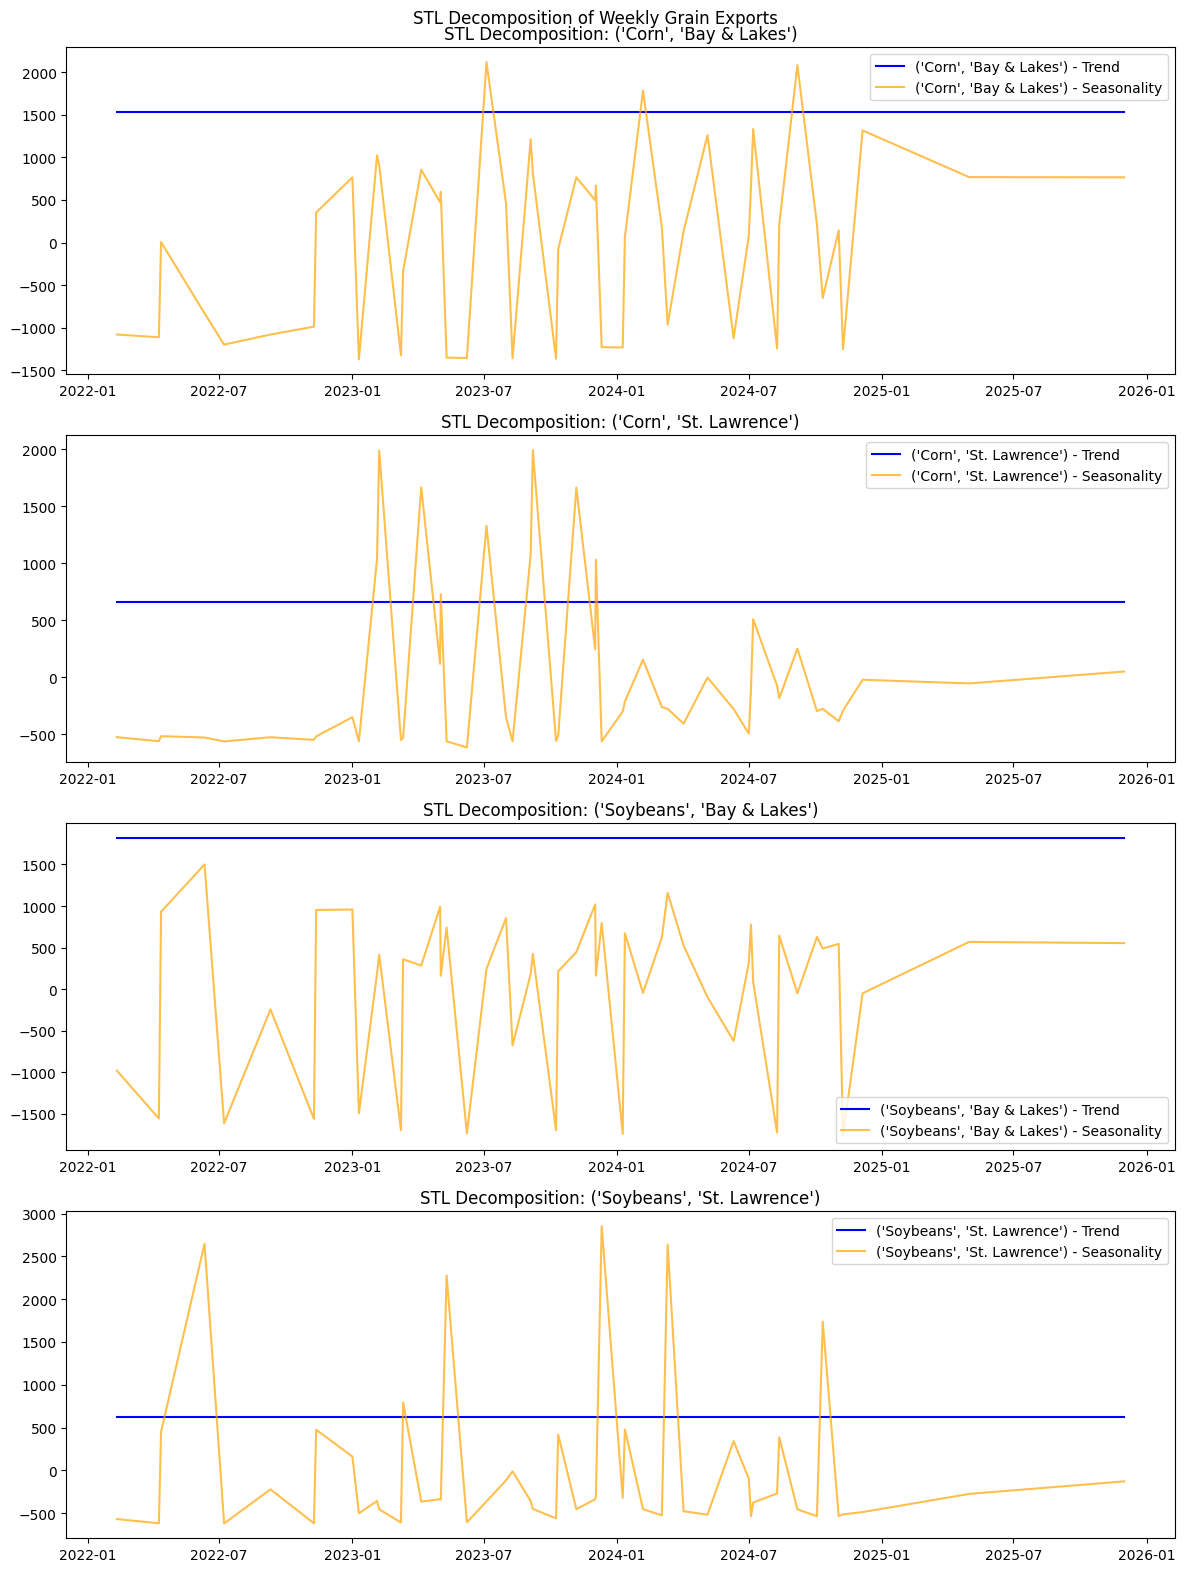

In [4]:
from statsmodels.tsa.seasonal import STL

# Plot STL decomposition for each grain-region combination
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
plt.suptitle("STL Decomposition of Weekly Grain Exports")

for i, col in enumerate(df_pivot.columns):
    series = df_pivot[col].dropna()
    stl = STL(series, period=52)  # Weekly data, so seasonality period = 52 weeks
    result = stl.fit()

    # Plot trend component
    axes[i].plot(series.index, result.trend, label=f"{col} - Trend", color="blue")
    axes[i].plot(series.index, result.seasonal, label=f"{col} - Seasonality", color="orange", alpha=0.7)
    axes[i].set_title(f"STL Decomposition: {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

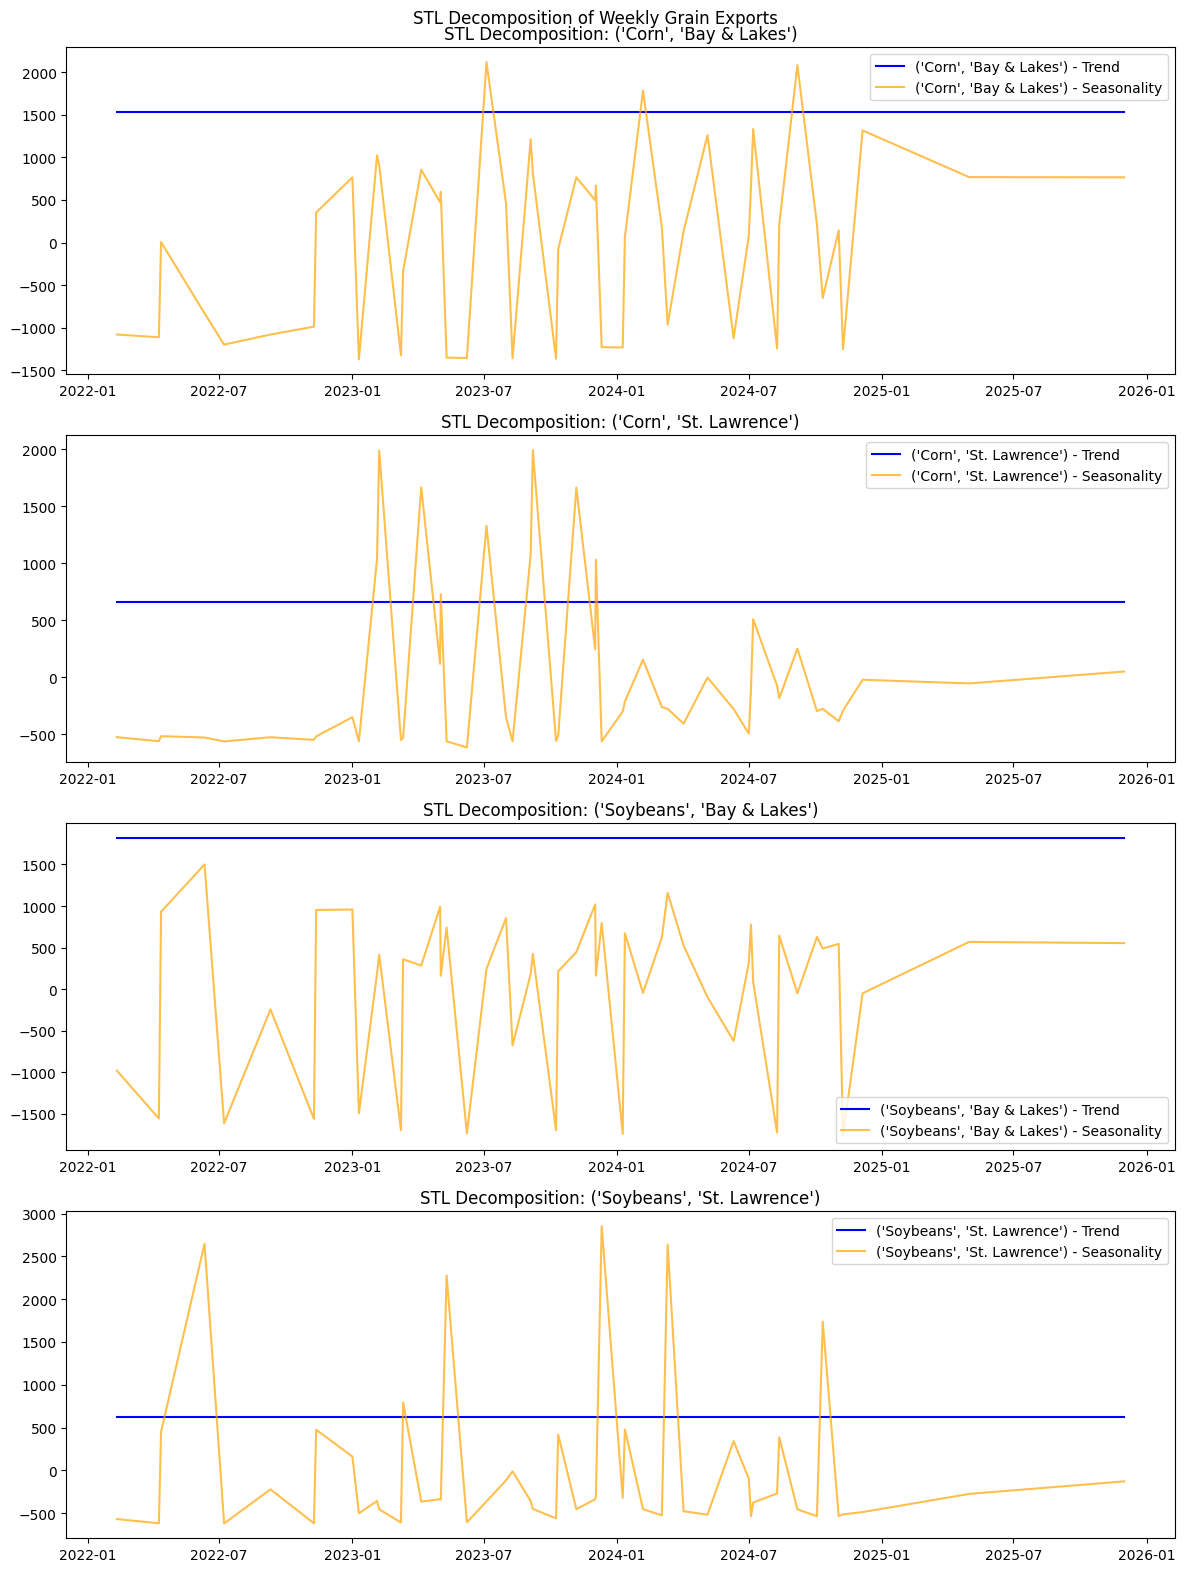

In [5]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Assuming df_pivot is your pivoted DataFrame with date index
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
plt.suptitle("STL Decomposition of Weekly Grain Exports")

for i, col in enumerate(df_pivot.columns):
    series = df_pivot[col].dropna()
    stl = STL(series, period=52)  # Weekly data, so seasonality period = 52 weeks
    result = stl.fit()

    # Plot trend component
    axes[i].plot(series.index, result.trend, label=f"{col} - Trend", color="blue")
    axes[i].plot(series.index, result.seasonal, label=f"{col} - Seasonality", color="orange", alpha=0.7)
    axes[i].set_title(f"STL Decomposition: {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [6]:
# Generate summary statistics for grain exports
summary_stats = df_filtered.groupby(["grain", "region"])["Ktonnes"].describe()

# Compute correlation matrix for numerical features
correlation_matrix = df_pivot.corr()

summary_stats, correlation_matrix

(                        count       mean         std  min  25%  50%     75%  \
 grain    region                                                               
 Corn     Bay & Lakes   3220.0  61.309938  138.179232  0.0  0.6  6.9  46.025   
          St. Lawrence  3272.0  27.109077   96.089543  0.0  0.0  0.5   9.300   
 Soybeans Bay & Lakes   2947.0  78.695521  165.297619 -2.5  0.2  7.2  42.800   
          St. Lawrence  2824.0  27.932011   91.097195  0.0  0.0  0.4   6.950   
 
                          max  
 grain    region               
 Corn     Bay & Lakes   998.5  
          St. Lawrence  889.6  
 Soybeans Bay & Lakes   986.0  
          St. Lawrence  982.8  ,
 grain                        Corn                 Soybeans             
 region                Bay & Lakes St. Lawrence Bay & Lakes St. Lawrence
 grain    region                                                        
 Corn     Bay & Lakes     1.000000     0.634776    0.523569    -0.300226
          St. Lawrence    0.63477

In [7]:
# Generate summary statistics for grain exports
summary_stats = df_filtered.groupby(["grain", "region"])["Ktonnes"].describe()
print(summary_stats)

                        count       mean         std  min  25%  50%     75%  \
grain    region                                                               
Corn     Bay & Lakes   3220.0  61.309938  138.179232  0.0  0.6  6.9  46.025   
         St. Lawrence  3272.0  27.109077   96.089543  0.0  0.0  0.5   9.300   
Soybeans Bay & Lakes   2947.0  78.695521  165.297619 -2.5  0.2  7.2  42.800   
         St. Lawrence  2824.0  27.932011   91.097195  0.0  0.0  0.4   6.950   

                         max  
grain    region               
Corn     Bay & Lakes   998.5  
         St. Lawrence  889.6  
Soybeans Bay & Lakes   986.0  
         St. Lawrence  982.8  


In [8]:
# Compute correlation matrix for numerical features
correlation_matrix = df_pivot.corr()
print(correlation_matrix)

grain                        Corn                 Soybeans             
region                Bay & Lakes St. Lawrence Bay & Lakes St. Lawrence
grain    region                                                        
Corn     Bay & Lakes     1.000000     0.634776    0.523569    -0.300226
         St. Lawrence    0.634776     1.000000    0.228064    -0.265257
Soybeans Bay & Lakes     0.523569     0.228064    1.000000     0.460453
         St. Lawrence   -0.300226    -0.265257    0.460453     1.000000


In [9]:
pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=aacd2eec8cb19ba8afa1da788865bfe2ca4854e37fbc10654002bc2f22f3b960
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [10]:
import pandas as pd
from ydata_profiling import ProfileReport

# Load your cleaned dataset
df = pd.concat(dataframes.values())  # Assuming you combined all datasets

# Generate the profiling report
profile = ProfileReport(df, title="Grain Export EDA Report", explorative=True)

# Save the report as an HTML file
profile.to_file("EDA_Report.html")

print("EDA report generated: EDA_Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]
/usr/local/lib/python3.11/dist-packages/ydata_profiling/model/correlations.py:87: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an axis with duplicate labels')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA report generated: EDA_Report.html


In [11]:
from ydata_profiling import ProfileReport

# Generate the EDA report
eda_report = ProfileReport(df_filtered, title="Grain Export EDA Report", explorative=True)

# Save the report as an HTML file
# Use a valid path where you want to save the report
# For example, to save it in the current directory, use:
eda_report_path = "EDA_Report.html"
eda_report.to_file(eda_report_path)

# Return the file path for download (if needed)
eda_report_path

/usr/local/lib/python3.11/dist-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 16.15it/s]
/usr/local/lib/python3.11/dist-packages/ydata_profiling/model/correlations.py:87: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an axis with duplicate labels')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

'EDA_Report.html'

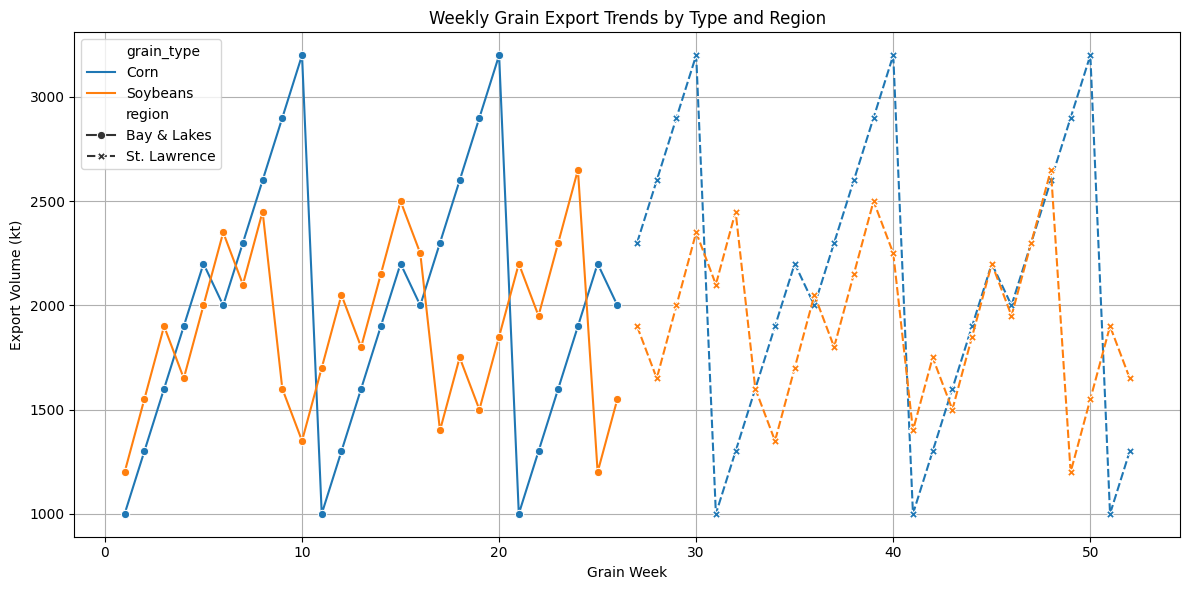

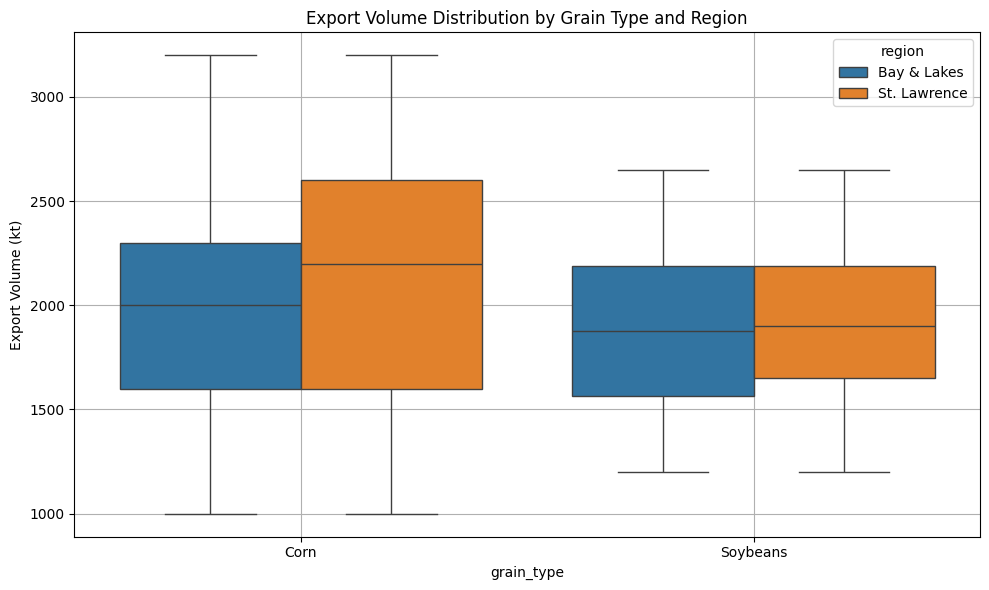

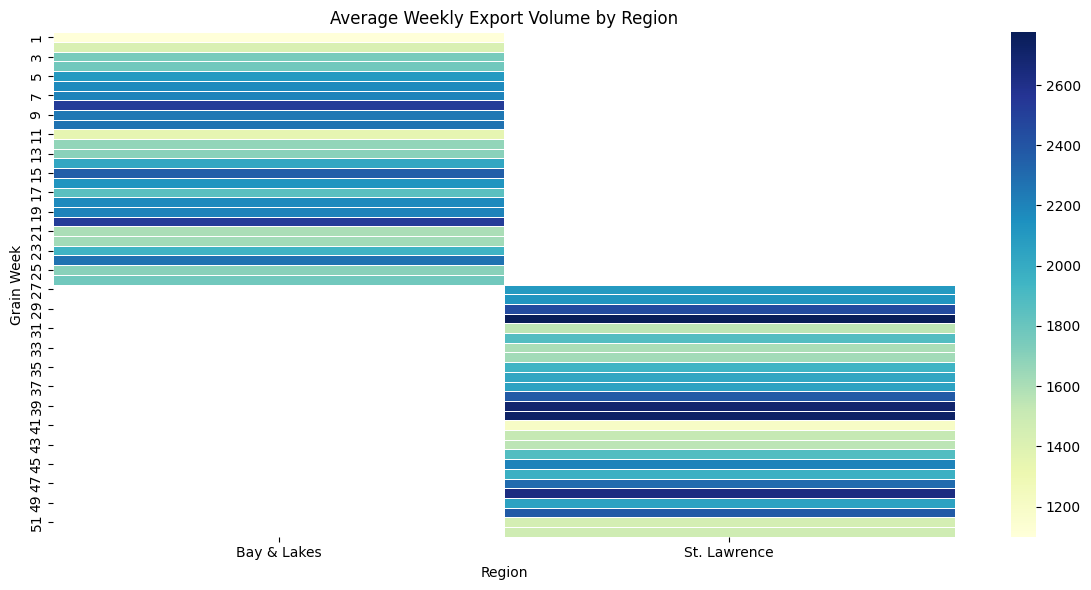

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged and cleaned dataset assumed to be the same used in EDA
# For visualization, let's simulate a sample version of it since actual data was not provided
# Example structure: crop_year, grain_type, region, grain_week, kt

# Simulated example data for visualization
data = {
    "grain_week": list(range(1, 53)) * 2,
    "kt": [abs(1000 + 200 * (i % 10) + (i % 5) * 100) for i in range(52)] +
          [abs(1200 + 150 * (i % 8) + (i % 3) * 200) for i in range(52)],
    "grain_type": ["Corn"] * 52 + ["Soybeans"] * 52,
    "region": ["Bay & Lakes"] * 26 + ["St. Lawrence"] * 26 + ["Bay & Lakes"] * 26 + ["St. Lawrence"] * 26
}

df = pd.DataFrame(data)

# Plot 1: Seasonality across grain weeks
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="grain_week", y="kt", hue="grain_type", style="region", markers=True)
plt.title("Weekly Grain Export Trends by Type and Region")
plt.xlabel("Grain Week")
plt.ylabel("Export Volume (kt)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Export Volume Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="grain_type", y="kt", hue="region")
plt.title("Export Volume Distribution by Grain Type and Region")
plt.ylabel("Export Volume (kt)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Heatmap of average exports by week and region
pivot = df.pivot_table(values='kt', index='grain_week', columns='region', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="YlGnBu", annot=False, linewidths=0.5)
plt.title("Average Weekly Export Volume by Region")
plt.xlabel("Region")
plt.ylabel("Grain Week")
plt.tight_layout()
plt.show()